# Домашняя работа. Панеш Али 193

## Формулы

### Вспомогательная функция
$
f_t(x,\mu) = tf(x, \mu) + F(x, \mu) = \\
t(\frac{1}{2}||Ax-b||_2^2+\lambda \langle 1, u\rangle) + \sum_{i=1}^n (- \ln(-(x_i - \mu_i)) - \ln(-(-x_i-\mu_i))) = \\
t(\frac{1}{2}||Ax-b||_2^2+\lambda \langle 1, u\rangle) + \sum_{i=1}^n (- \ln (\mu_i - x_i) - \ln(x_i+\mu_i))
$

### Направление
$
d_k = (d_k^x, d_k^\mu)\\
d_k^x = -[\nabla^2f_t(x, \mu)_x]^{-1}\nabla f_t(x, \mu)_x\\
d_k^\mu = -[\nabla^2f_t(x, \mu)_\mu]^{-1}\nabla f_t(x, \mu)_\mu\\
$

#### Для х:
$\\
d^xf_t(x,\mu) = 
t \langle Ax - b, Adx\rangle + \sum_{i=1}^n (\frac{1}{\mu_i - x_i} - \frac{1}{\mu_i + x_i})d_{x_i}
=\\
t \langle A^T(Ax - b), dx\rangle + \sum_{i=1}^n (\frac{1}{\mu_i - x_i} - \frac{1}{\mu_i + x_i})d_{x_i}
\\
\nabla_x f_t(x, \mu)_i = (tA^T(Ax - b))_i + \frac{1}{\mu_i - x_i} - \frac{1}{\mu_i + x_i}
\\
d [f_t(x, \mu)][dx, dx] = 
t \langle A^TAdx, dx\rangle + \sum_{i=1}^n (\frac{1}{(\mu_i - x_i)^2} + \frac{1}{(\mu_i + x_i)^2})d_{x_i}
\\
\nabla^2_x f_t(x, \mu)_{ii} = (tA^TA)_{ii} + \frac{1}{(\mu_i - x_i)^2} + \frac{1}{(\mu_i + x_i)^2}\\
\nabla^2_x f_t(x, \mu)_{ij, i\ne j} = 
(tA^TA)_{ij, i\ne j}$

#### Для $\mu:\\$
$
d^\mu f_t(x,\mu) = 
t\lambda \langle 1, d\mu\rangle + \sum_{i=1}^n (- \frac{1}{\mu_i - x_i} - \frac{1}{x_i+\mu_i})d_{\mu_i}
\\
\nabla_\mu f_t(x, \mu)_i = t\lambda - \frac{1}{\mu_i - x_i} - \frac{1}{x_i+\mu_i}
\\
d^\mu f_t(x,\mu)[d\mu d\mu] = d(\sum_{i=1}^n (- \frac{1}{\mu_i - x_i} - \frac{1}{x_i+\mu_i}))=
\sum_{i=1}^n (\frac{1}{(\mu_i - x_i)^2} + \frac{1}{(x_i+\mu_i)^2})d_{\mu_i} d_{\mu_i}
\\
\nabla^2_\mu f_t(x, \mu)_{ii} = \frac{1}{(\mu_i - x_i)^2} + \frac{1}{(x_i+\mu_i)^2}
\\
\nabla^2_\mu f_t(x, \mu)_{ij, i\ne j} = 0$

#### Смешанная часть гессиана:
$
\nabla^2_\mu f_t(x, \mu)_{i_x, i_\mu} =
d/d^{\mu_i}(\frac{1}{\mu_i - x_i} - \frac{1}{\mu_i + x_i}) = 
\frac{1}{(\mu_i + x_i)^2} - \frac{1}{(\mu_i - x_i)^2}
\\
\nabla^2_\mu f_t(x, \mu)_{i_\mu, i_x} =
d/d^{x_i}(- \frac{1}{\mu_i - x_i} - \frac{1}{x_i+\mu_i}) = 
\frac{1}{(x_i+\mu_i)^2} - \frac{1}{(\mu_i - x_i)^2} = \nabla^2_\mu f_t(x, \mu)_{i_x, i_\mu}
$

### Максимальное $\alpha$

$g_i(x, \mu) = \langle q, (x, \mu) \rangle$, где $(x, \mu)$ - вектор состоящий из х и $\mu$, а $q = (..., \pm 1,..., -1, ...)$ это вектор где на $i_x (=i)$ месте стоит коэфицент для $x_i$, на $i_\mu (=i + n)$ стоит коэфицент для $\mu_i$, а в остальных местах 0.

Тогда $\alpha_{\max} = \min\limits_{i\in I} \frac{\langle q_i, (x, \mu) \rangle}{\langle q_i, d \rangle} = \min\limits_{i\in I} \frac{sgn(q_{ij})x_j - \mu_j}{sgn(q_{ij})d_j-d_{j+n}}$, где $I$ - множество индексов, где знаменатель больше 0.

### Начальная точка

В данной задаче нам нужно выбрать подходящую под условия начальную точку: $x = 0_n, \mu = 1_n$

### Способ решения

Предлагаю взять для больших матриц способ `LBFGS`, чтобы наши вычисления поместились в RAM и не было потребности вычислять гессиан, а для маленьких использовать `newton`, чтобы увеличить точность.

## Эксперемент с методом барьеров

### Подготовка

In [72]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import product
from oracles import BarrierOracle, lasso_duality_gap
from optimization import barrier_method_lasso, newton, lbfgs
import pandas as pd
import random
import numpy as np
%autoreload 2


def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)


In [345]:
def test_barrier(n=500, m=5000, eps_inner=1e-3, gamma=10, lambd=1., A=None, b=None):
    if A is None:
        A = 50 * np.random.rand(m, n) - 100
    if b is None:
        b = 5 * np.random.rand(m) - 10
    return barrier_method_lasso(
        A, b, lambd, np.zeros(n), np.ones(n), tolerance_inner=eps_inner,
        gamma=gamma, lasso_duality_gap=lasso_duality_gap, trace=True)


def plot_ldg_over_time_or_iter(df, name, list_of_elements, ax=None, is_time=True):
    colors = ['g', 'r', 'b', 'y', 'm', 'c', 'k']
    if ax is not None:
        plt.sca(ax)
    for i, elem in enumerate(list_of_elements):
        rows = df.loc[(df[name] == elem)]
        if len(rows.index) == 0:
            continue
        ldg = list(rows['duality_gap'])[0]
        time = list(rows['time'])[0]
        if is_time:
            plt.plot(time, ldg, color=colors[i % len(colors)], linewidth=2, label=f'{name}: {elem}')
        else:
            plt.plot(range(len(time)), ldg, color=colors[i % len(colors)], linewidth=2, label=f'{name}: {elem}')

    if is_time:
        plt.xlabel('Time')
        plt.title('Duality gap over time')
    else:
        plt.xlabel('Iteration')
        plt.title('Duality gap over iterations')

    plt.ylabel('Duality gap')
    plt.yscale('log')
    plt.legend()

def plot_ldg_over_time_and_iter(df, name, list_of_elements):
    _, axs = plt.subplots(1, 2, figsize=(16, 7))
    plot_ldg_over_time_or_iter(df, name, list_of_elements, axs[0])
    plot_ldg_over_time_or_iter(df, name, list_of_elements, axs[1], is_time=False)

In [347]:
set_random_seed(107)

gamma_ = np.linspace(10, 300, 5, dtype=float)
eps_inner_ = np.logspace(-8, -1, 5)
n_ = np.linspace(100, 1000, 5, dtype=int)
m_ = np.linspace(100, 10000, 5, dtype=int)
lambdas_ = np.logspace(-2, 3, 5)

n = 500
m = 5000
A = 50 * np.random.rand(m, n) - 100
b = 5 * np.random.rand(m) - 10

df_n = pd.DataFrame(columns=['n', 'func', 'duality_gap', 'time'])
df_m = pd.DataFrame(columns=['m', 'func', 'duality_gap', 'time'])
df_gamma = pd.DataFrame(columns=['gamma', 'func', 'duality_gap', 'time'])
df_eps = pd.DataFrame(columns=['eps', 'func', 'duality_gap', 'time'])
df_lambda = pd.DataFrame(columns=['lambda', 'func', 'duality_gap', 'time'])

for i, gamma in enumerate(gamma_):
    _, msg, history = test_barrier(gamma=gamma, A=A, b=b)
    if msg != 'success':
        print(msg)
        continue
    df_gamma.loc[i] = [gamma, history['func'], history['duality_gap'], history['time']]

for i, eps in enumerate(eps_inner_):
    _, msg, history = test_barrier(eps_inner=eps, A=A, b=b)
    if msg != 'success':
        continue
    df_eps.loc[i] = [eps, history['func'], history['duality_gap'], history['time']]

for i, lambd in enumerate(lambdas_):
    _, msg, history = test_barrier(lambd=lambd, A=A, b=b)
    if msg != 'success':
        continue
    df_lambda.loc[i] = [lambd, history['func'], history['duality_gap'], history['time']]

for i, m in enumerate(m_):
    _, msg, history = test_barrier(m=m)
    if msg != 'success':
        continue
    df_m.loc[i] = [m, history['func'], history['duality_gap'], history['time']]

for i, n in enumerate(n_):
    _, msg, history = test_barrier(n=n)
    if msg != 'success':
        continue
    df_n.loc[i] = [n, history['func'], history['duality_gap'], history['time']]

clear_output()

In [348]:
result_config = {
    'eps': [df_eps, 'eps', eps_inner_],
    'm': [df_m, 'm', m_],
    'n': [df_n, 'n', n_],
    'gamma': [df_gamma, 'gamma', gamma_],
    'lambda': [df_lambda, 'lambda', lambdas_],
}

### Результаты

#### Размер выборки

Время сходимости от размера выборки пропорционально размеру выборки, что логично из-за меньшего количества вычислений, тогда как количество внешних итераций в целом не сильно зависит от этого параметра.

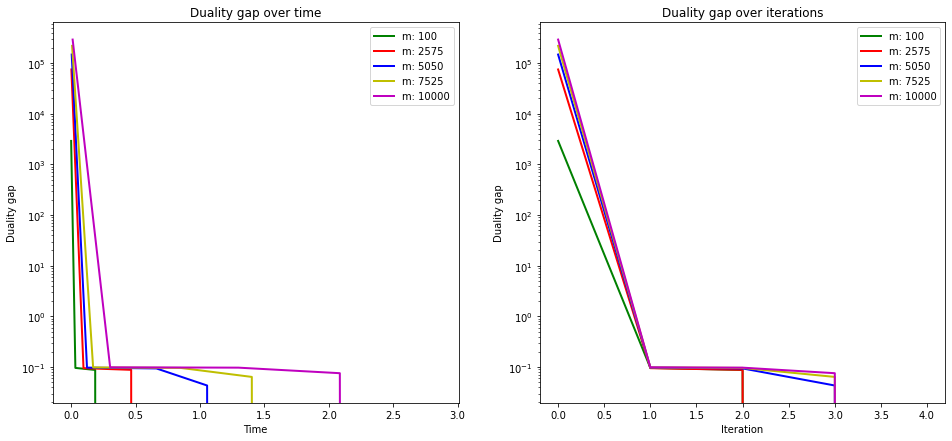

In [342]:
plot_ldg_over_time_and_iter(*result_config['m'])

#### Размерность

Время сходимости в заисимости пропорцианально размерности, тогда как необходимое количество итераций обратно пропорционально. Что логично, потому что на большой выборке дольше обучать Ньютона, однако она более стабильна. 

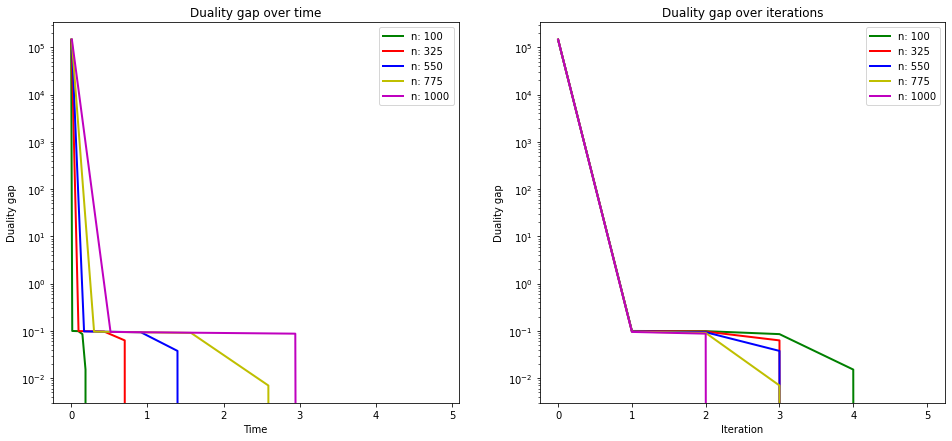

In [341]:
plot_ldg_over_time_and_iter(*result_config['n'])

#### Gamma

При больших $\gamma$ сходимость достигается быстрее. Видимо, потому что всё большую часть занимает не добавок (F(x)), который нужен лишь для того, чтобы сделать бортики, а сама функция.

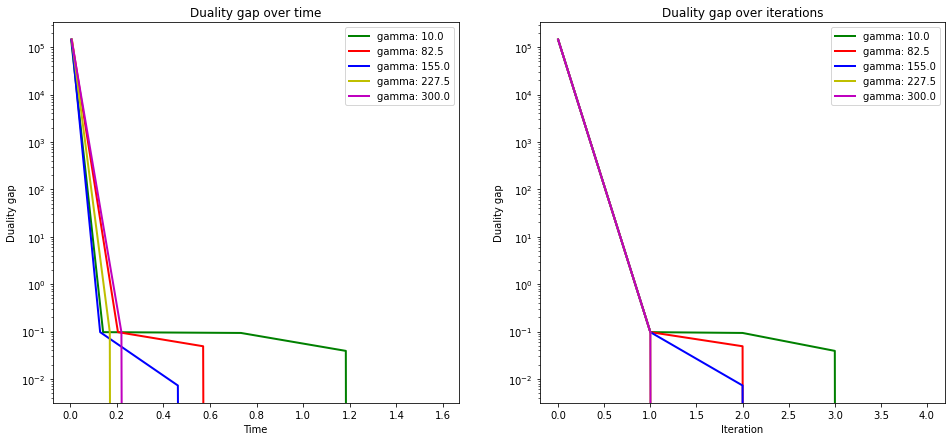

In [340]:
plot_ldg_over_time_and_iter(*result_config['gamma'])

#### Epsilon

Как мы видим от $\varepsilon_{inner}$ скорость вычисления результата зависит не сильно. Скорее всего это вызванно довольно быстрым и точным нахождением в Ньютоне. Однако немного зависит конечный результат.

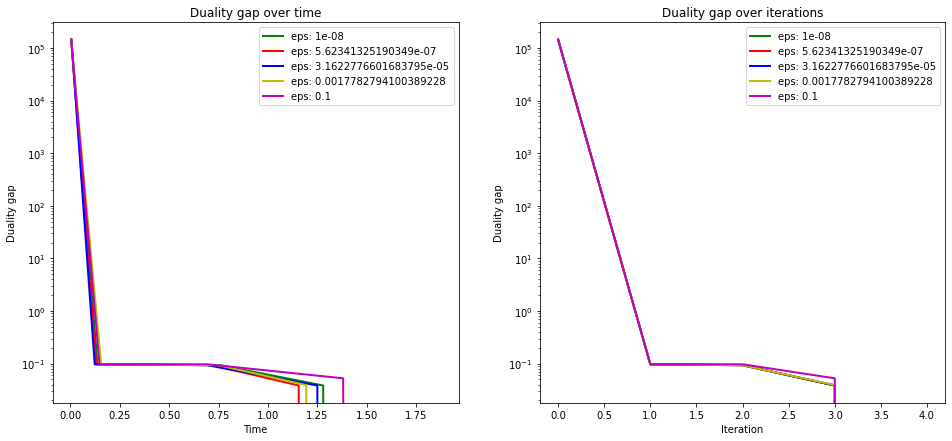

In [339]:
plot_ldg_over_time_and_iter(*result_config['eps'])

#### Коэфицент регуляризации

Как можно заметить зависимость нелинейна.

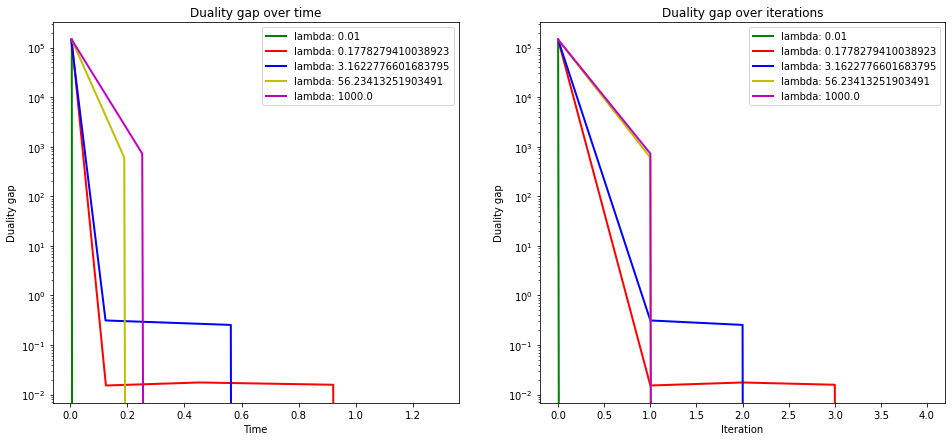

In [349]:
plot_ldg_over_time_and_iter(*result_config['lambda'])